# data prepare

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('/home/young/liuyixin/dl_learning/material/dataset/cov-19-global-predict/covid19-global-forecasting-week-4'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/young/liuyixin/dl_learning/material/dataset/cov-19-global-predict/covid19-global-forecasting-week-4/test.csv
/home/young/liuyixin/dl_learning/material/dataset/cov-19-global-predict/covid19-global-forecasting-week-4/train.csv
/home/young/liuyixin/dl_learning/material/dataset/cov-19-global-predict/covid19-global-forecasting-week-4/submission.csv


In [2]:
train_df = gpd.read_file("/home/young/liuyixin/dl_learning/material/dataset/cov-19-global-predict/covid19-global-forecasting-week-4/train.csv")
train_df["ConfirmedCases"] = train_df["ConfirmedCases"].astype("float")
train_df["Fatalities"] = train_df["Fatalities"].astype("float")
#The country_region got modified in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe to facilitate the merge.
train_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in train_df.iterrows()]

In [3]:
#Still using the enriched data from week 2 as there is everything required for the model's training
extra_data_df = gpd.read_file("/home/young/liuyixin/dl_learning/material/dataset/cov-19-global-predict/enriched_covid_19_week_2.csv")
extra_data_df["Country_Region"] = [country_name.replace("'","") for country_name in extra_data_df["Country_Region"]]
extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
extra_data_df["density"] = extra_data_df["density"].astype("float")
extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
extra_data_df["lung"] = extra_data_df["lung"].astype("float")
extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

extra_data_df = extra_data_df[["Country_Region","Date","restrictions","quarantine","schools","hospibed","lung","total_pop","density","age_100+"]]
extra_data_df.head()

,Country_Region,Date,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,Afghanistan,2020-01-22,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
1,Afghanistan,2020-01-23,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
2,Afghanistan,2020-01-24,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
3,Afghanistan,2020-01-25,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
4,Afghanistan,2020-01-26,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411


In [4]:
train_df = train_df.merge(extra_data_df, how="left", on=['Country_Region','Date']).drop_duplicates()
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411


In [5]:
for country_region in train_df.Country_Region.unique():
    query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]

In [6]:
median_pop = np.median(extra_data_df.total_pop)
median_hospibed = np.median(extra_data_df.hospibed)
median_density = np.median(extra_data_df.density)
median_lung = np.median(extra_data_df.lung)
median_centenarian_pop = np.median(extra_data_df["age_100+"])
#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in train_df.Country_Region.unique():
    if extra_data_df.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        train_df.loc[train_df["Country_Region"]==country_region,"total_pop"] = median_pop
        train_df.loc[train_df["Country_Region"]==country_region,"hospibed"] = median_hospibed
        train_df.loc[train_df["Country_Region"]==country_region,"density"] = median_density
        train_df.loc[train_df["Country_Region"]==country_region,"lung"] = median_lung
        train_df.loc[train_df["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        train_df.loc[train_df["Country_Region"]==country_region,"restrictions"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"quarantine"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"schools"] = 0

The missing countries/region are:
Botswana
Burma
Burundi
Canada_Northwest Territories
Canada_Yukon
France_Saint Pierre and Miquelon
Kosovo
MS Zaandam
Malawi
Netherlands_Bonaire, Sint Eustatius and Saba
Sao Tome and Principe
Sierra Leone
South Sudan
United Kingdom_Anguilla
United Kingdom_British Virgin Islands
United Kingdom_Falkland Islands (Malvinas)
United Kingdom_Turks and Caicos Islands
West Bank and Gaza
Western Sahara


In [7]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [8]:
train_df

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35990,35991,,Zimbabwe,2020-05-11,36.0,4.0,None,0.0,0.0,0.0,0.195652,0.180347,0.010326,0.003607,0.001801
35991,35992,,Zimbabwe,2020-05-12,36.0,4.0,None,0.0,0.0,0.0,0.195652,0.180347,0.010326,0.003607,0.001801
35992,35993,,Zimbabwe,2020-05-13,37.0,4.0,None,0.0,0.0,0.0,0.195652,0.180347,0.010326,0.003607,0.001801
35993,35994,,Zimbabwe,2020-05-14,37.0,4.0,None,0.0,0.0,0.0,0.195652,0.180347,0.010326,0.003607,0.001801


In [9]:
#Just getting rid of the first days to have a multiple of 7
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
days_in_sequence = 21

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/3)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)
                    centenarian_pop = float(province_df.iloc[i]["age_100+"])

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 313/313 [00:12<00:00, 27.44it/s]


In [10]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [11]:
trend_df.head()

,infection_trend,fatality_trend,restriction_trend,quarantine_trend,school_trend,demographic_inputs,expected_cases,expected_fatalities,temporal_inputs
442,"[65.0, 82.0, 96.0, 104.0, 113.0, 126.0, 135.0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.003607092683297262, 0.1956521739130435...",306.0,4.0,"[[65.0, 82.0, 96.0, 104.0, 113.0, 126.0, 135.0..."
1178,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0003755527489814116, 0.06842085279264913, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2145,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.023253419143481755, 0.002999582336636671, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1713,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2322267255206195, 0.003607092683297262, 0.1...",19.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
328,"[22.0, 25.0, 28.0, 29.0, 34.0, 36.0, 41.0, 42....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.026222145205808296, 0.003607092683297262, 0...",688.0,8.0,"[[22.0, 25.0, 28.0, 29.0, 34.0, 36.0, 41.0, 42..."


In [12]:
i=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<25:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [13]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
442,"[1.0, 0.003607092683297262, 0.1956521739130435...",306.0,4.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[65.0, 82.0, 96.0, 104.0, 113.0, 126.0, 135.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[65.0, 82.0, 96.0, 104.0, 113.0, 126.0, 135.0..."
1178,"[0.0003755527489814116, 0.06842085279264913, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2145,"[0.023253419143481755, 0.002999582336636671, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1713,"[0.2322267255206195, 0.003607092683297262, 0.1...",19.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
328,"[0.026222145205808296, 0.003607092683297262, 0...",688.0,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22.0, 25.0, 28.0, 29.0, 34.0, 36.0, 41.0, 42....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[22.0, 25.0, 28.0, 29.0, 34.0, 36.0, 41.0, 42..."


In [14]:
sequence_length = 20
training_percentage = 0.9

In [15]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [16]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [17]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length)),(0,2,1)) ).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

In [18]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,5))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(5))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

# cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

# fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           96          input_2[0][0]                    
______________________________________________________________________________________________

In [19]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [20]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

596 - lr: 7.7760e-05
Epoch 113/250
61/61 [==============================] - 2s 32ms/step - loss: 0.3519 - cases_loss: 0.2784 - fatalities_loss: 0.0735 - val_loss: 0.2924 - val_cases_loss: 0.2321 - val_fatalities_loss: 0.0603 - lr: 7.7760e-05
Epoch 114/250
61/61 [==============================] - 2s 30ms/step - loss: 0.3465 - cases_loss: 0.2752 - fatalities_loss: 0.0713 - val_loss: 0.2986 - val_cases_loss: 0.2337 - val_fatalities_loss: 0.0649 - lr: 7.7760e-05
Epoch 115/250
61/61 [==============================] - 2s 30ms/step - loss: 0.3458 - cases_loss: 0.2762 - fatalities_loss: 0.0696 - val_loss: 0.2965 - val_cases_loss: 0.2385 - val_fatalities_loss: 0.0580 - lr: 7.7760e-05
Epoch 116/250
61/61 [==============================] - ETA: 0s - loss: 0.3464 - cases_loss: 0.2749 - fatalities_loss: 0.0715
Epoch 00116: ReduceLROnPlateau reducing learning rate to 4.6655999904032795e-05.
61/61 [==============================] - 2s 26ms/step - loss: 0.3464 - cases_loss: 0.2749 - fatalities_loss: 0

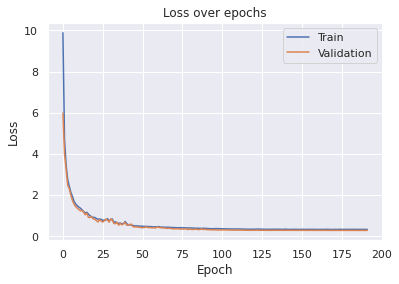

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

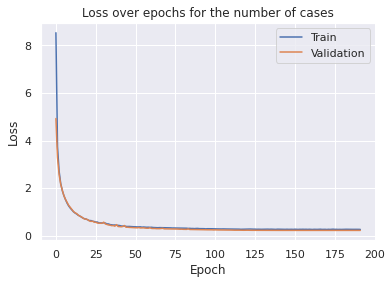

In [22]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

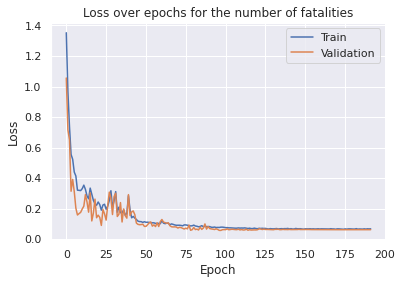

In [23]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [24]:
model.load_weights("best_model.h5")

In [25]:
predictions = model.predict([X_temporal_test,X_demographic_test])

In [ ]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )